# keras-nlp/example/machine_translation

- https://github.com/keras-team/keras-nlp/tree/master/examples/machine_translation

```
# Copyright 2023 The KerasNLP Authors
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
```

In [25]:
# The hyperparameters, especially of the optimizer, seem picky.
# Currently, only the following versions go well only on mac with RMSprop.
%pip install -U tensorflow==2.15.1 tensorflow-macos==2.15.1 keras==2.15.0
#%pip install keras-nlp

  Using cached tensorflow-2.15.1-cp310-cp310-macosx_12_0_arm64.whl.metadata (4.0 kB)
  Using cached tensorflow_macos-2.15.1-cp310-cp310-macosx_12_0_arm64.whl.metadata (3.4 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached tensorboard-2.15.2-py3-none-any.whl.metadata (1.7 kB)
Using cached tensorflow-2.15.1-cp310-cp310-macosx_12_0_arm64.whl (205.7 MB)
Using cached tensorflow_macos-2.15.1-cp310-cp310-macosx_12_0_arm64.whl (2.2 kB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
Using cached tensorboard-2.15.2-py3-none-any.whl (5.5 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.2
    Uninstalling 

In [18]:
# This version can not use keras.optimizers.legacy.RMSprop.
# And the model does not converge.
%pip install -U tensorflow==2.16.2 tensorflow-macos==2.16.2 keras==3.4.1
#%pip install keras-nlp

  Using cached tensorflow-2.16.2-cp310-cp310-macosx_12_0_arm64.whl.metadata (4.1 kB)
  Using cached tensorflow_macos-2.16.2-cp310-cp310-macosx_12_0_arm64.whl.metadata (3.3 kB)
  Using cached keras-3.4.1-py3-none-any.whl.metadata (5.8 kB)
  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
Using cached tensorflow-2.16.2-cp310-cp310-macosx_12_0_arm64.whl (227.0 MB)
Using cached tensorflow_macos-2.16.2-cp310-cp310-macosx_12_0_arm64.whl (2.1 kB)
Using cached keras-3.4.1-py3-none-any.whl (1.1 MB)
Using cached tensorboard-2.16.2-py3-none-any.whl (5.5 MB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.1
    Uninstalling

In [1]:
import tensorflow as tf
import keras
import keras_nlp
print(tf.__version__)
print(keras.__version__)
print(keras_nlp.__version__)

# SageMaker cannot use @keras.saving
from keras import saving

2.16.2
3.4.1
0.12.1


# Utility function

In [2]:
import platform

def is_running_on_apple_sillicon():
    return platform.system() == "Darwin" and platform.processor() == "arm"

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot(history, title=None, keys=["loss", "masked_acc"]):
    """
    Display the plot that indicates the loss and accuracy.
    :param history: history object from the tensorflow fit function.
    :param title: title text.
    :param keys: keys for plotting.
    """
    flg, axes = plt.subplots(1, 2, tight_layout=True)
    if title is not None:
        flg.suptitle(t=title, fontsize=14)
    for i, key in enumerate(keys):
        value = history.history[key]
        val_loss = history.history[f"val_{key}"]
        epochs = range(1, len(value) + 1)
        axes[i].plot(epochs, value, label=f"Training {key}")
        axes[i].plot(epochs, val_loss, label=f"Validation {key}")
        axes[i].set_title(f"Training and validation {key}")
        axes[i].set_xlabel("epochs")
        axes[i].set_ylabel(key)
        axes[i].legend()
    plt.show()

    for key in keys:
        if 'loss' in key:
            print(
                np.min(history.history[f"val_{key}"]),
                "The best number of epocs for the validation loss is",
                np.argmin(history.history[f"val_{key}"]) + 1,
            )
        else:
            print(
                np.max(history.history[f"val_{key}"]),
                "The best number of epocs for the validation accuracy is",
                np.argmax(history.history[f"val_{key}"]) + 1,
            )
    

In [5]:
# @see https://www.tensorflow.org/text/tutorials/nmt_with_attention
@saving.register_keras_serializable()
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = keras.losses.SparseCategoricalCrossentropy(
        # nn.py:609: UserWarning:
        # "`sparse_categorical_crossentropy` received `from_logits=True`,
        # but the `output` argument was produced by a Softmax activation and thus does not represent logits.
        # Was this intended?
        # from_logits=True,
        reduction='none'
    )
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, dtype=loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [6]:
# @see https://www.tensorflow.org/text/tutorials/nmt_with_attention
# def masked_acc(y_true, y_pred):
#     # Calculate the loss for each item in the batch.
#     y_pred = tf.argmax(y_pred, axis=-1)
#     y_pred = tf.cast(y_pred, dtype=y_true.dtype)
#     match = tf.cast(y_true == y_pred, dtype=tf.float32)
#     mask = tf.cast(y_true != 0, dtype=tf.float32)
#     return tf.reduce_sum(match)/tf.reduce_sum(mask)

# @see https://www.tensorflow.org/text/tutorials/transformer
@saving.register_keras_serializable()
def masked_acc(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=2)
    y_true = tf.cast(y_true, dtype=y_pred.dtype)
    match = y_true == y_pred
    mask = y_true != 0
    match = match & mask
    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

## Dataset

In [7]:
import pathlib
import random
import re
import string


def download_data():
    text_file = keras.utils.get_file(
        fname="spa-eng.zip",
        origin=(
            "http://storage.googleapis.com/download.tensorflow.org/data/"
            + "spa-eng.zip"
        ),
        extract=True,
    )
    return pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"


def read_data(filepath):
    with open(filepath) as f:
        lines = f.read().split("\n")[:-1]
        text_pairs = []
        for line in lines:
            eng, spa = line.split("\t")
            spa = "[start] " + spa + " [end]"
            text_pairs.append((eng, spa))
    return text_pairs


def split_train_val_test(text_pairs):
    random.shuffle(text_pairs)
    num_val_samples = int(0.15 * len(text_pairs))
    num_train_samples = len(text_pairs) - 2 * num_val_samples
    train_pairs = text_pairs[:num_train_samples]
    val_end_index = num_train_samples + num_val_samples
    val_pairs = text_pairs[num_train_samples:val_end_index]
    test_pairs = text_pairs[val_end_index:]
    return train_pairs, val_pairs, test_pairs


strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")


@saving.register_keras_serializable()
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase,
        "[%s]" % re.escape(strip_chars),
        "",
    )


def prepare_tokenizer(train_pairs, sequence_length, vocab_size):
    """Preapare English and Spanish tokenizer."""
    eng_tokenizer = keras.layers.TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        output_sequence_length=sequence_length,
    )
    spa_tokenizer = keras.layers.TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        output_sequence_length=sequence_length + 1,
        standardize=custom_standardization,
    )
    eng_texts, spa_texts = zip(*train_pairs)
    eng_tokenizer.adapt(eng_texts)
    spa_tokenizer.adapt(spa_texts)
    return eng_tokenizer, spa_tokenizer


def prepare_datasets(text_pairs, batch_size, eng_tokenizer, spa_tokenizer):
    """Transform raw text pairs to tf datasets."""
    eng_texts, spa_texts = zip(*text_pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)

    def format_dataset(eng, spa):
        """Format the dataset given input English and Spanish text.

        The output format is:
            x: a pair of English and Spanish sentence.
            y: The Spanish sentence in x shifts 1 token towards right, because
                we are predicting the next token.
        """
        eng = eng_tokenizer(eng)
        spa = spa_tokenizer(spa)
        return (
            {
                "encoder_inputs": eng,
                "decoder_inputs": spa[:, :-1],
            },
            spa[:, 1:],
            tf.cast((spa[:, 1:] != 0), "float32"),  # mask as sample weights
        )

    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(tf.data.AUTOTUNE).cache()


def get_dataset_and_tokenizer(sequence_length, vocab_size, batch_size):
    """Main method to get the formatted machine translation dataset."""
    filepath = download_data()
    text_pairs = read_data(filepath)
    train_pairs, val_pairs, test_pairs = split_train_val_test(text_pairs)
    eng_tokenizer, spa_tokenizer = prepare_tokenizer(
        train_pairs, sequence_length, vocab_size
    )
    train_ds = prepare_datasets(
        train_pairs,
        batch_size,
        eng_tokenizer,
        spa_tokenizer,
    )
    val_ds = prepare_datasets(
        val_pairs,
        batch_size,
        eng_tokenizer,
        spa_tokenizer,
    )
    test_ds = prepare_datasets(
        test_pairs,
        batch_size,
        eng_tokenizer,
        spa_tokenizer,
    )
    return (train_ds, val_ds, test_ds), (eng_tokenizer, spa_tokenizer)

## Model

In [8]:
@saving.register_keras_serializable()
class TranslationModel(keras.Model):
    """The machine translation model.

    The model is an encoder-decoder structure model. The encoder is a stack of
    `keras_nlp.TransformerEncoder`, and the decoder is a stack of
    `keras_nlp.TransformerDecoder`. We also pass in the tokenizer for encoder
    and decoder so that during save/load, the tokenizer is also kept.
    """

    def __init__(
        self,
        encoder_tokenizer,
        decoder_tokenizer,
        num_encoders,
        num_decoders,
        num_heads,
        transformer_intermediate_dim,
        encoder_vocabulary_size,
        decoder_vocabulary_size,
        embedding_dim,
        sequence_length,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.encoders = []
        self.decoders = []
        for _ in range(num_encoders):
            self.encoders.append(
                keras_nlp.layers.TransformerEncoder(
                    num_heads=num_heads,
                    intermediate_dim=transformer_intermediate_dim,
                )
            )
        for _ in range(num_decoders):
            self.decoders.append(
                keras_nlp.layers.TransformerDecoder(
                    num_heads=num_heads,
                    intermediate_dim=transformer_intermediate_dim,
                )
            )

        self.encoder_tokenizer = encoder_tokenizer
        self.decoder_tokenizer = decoder_tokenizer

        self.encoder_embedding = keras_nlp.layers.TokenAndPositionEmbedding(
            vocabulary_size=encoder_vocabulary_size,
            sequence_length=sequence_length,
            embedding_dim=embedding_dim,
            mask_zero=True,
        )

        self.decoder_embedding = keras_nlp.layers.TokenAndPositionEmbedding(
            vocabulary_size=decoder_vocabulary_size,
            sequence_length=sequence_length,
            embedding_dim=embedding_dim,
            mask_zero=True,
        )

        self.dense = keras.layers.Dense(
            decoder_vocabulary_size,
            activation="softmax",
        )

    def call(self, inputs):
        encoder_input, decoder_input = (
            inputs["encoder_inputs"],
            inputs["decoder_inputs"],
        )
        encoded = self.encoder_embedding(encoder_input)
        for encoder in self.encoders:
            encoded = encoder(inputs=encoded)

        decoded = self.decoder_embedding(decoder_input)
        for decoder in self.decoders:
            decoded = decoder(
                decoder_sequence=decoded,
                encoder_sequence=encoded,
                use_causal_mask=True,
            )

        output = self.dense(decoded)
        return output

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            "encoder_tokenizer": self.encoder_tokenizer.get_config(),
            "decoder_tokenizer": self.decoder_tokenizer.get_config(),
            "num_encoders": len(self.encoders),
            "num_decoders": len(self.decoders),
            "num_heads": self.encoders[0].num_heads,
            "transformer_intermediate_dim": self.encoders[0].intermediate_dim,
            "encoder_vocabulary_size": self.encoder_embedding.vocabulary_size,
            "decoder_vocabulary_size": self.decoder_embedding.vocabulary_size,
            "embedding_dim": self.encoder_embedding.embedding_dim,
            "sequence_length": self.encoder_embedding.sequence_length,
        })
        return config
    @classmethod
    def from_config(cls, config):
        encoder_tokenizer_config = config.pop("encoder_tokenizer")
        decoder_tokenizer_config = config.pop("decoder_tokenizer")
        encoder_tokenizer = keras.layers.TextVectorization.from_config(encoder_tokenizer_config)
        decoder_tokenizer = keras.layers.TextVectorization.from_config(decoder_tokenizer_config)
        return cls(encoder_tokenizer=encoder_tokenizer, decoder_tokenizer=decoder_tokenizer, **config)

## Train

In [9]:
def run_training(
        model,
        train_ds,
        val_ds,
        initial_learning_rate,
        decay_steps,
        decay_rate,
        epochs,
        steps_per_epoch):
    if decay_rate < 1.0:
        learning_rate = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=initial_learning_rate,
            decay_steps=decay_steps,
            decay_rate=decay_rate,
        )
    else:
        learning_rate = initial_learning_rate
    if f"{keras.__version__}".startswith("2.") and is_running_on_apple_sillicon():
        optimizer = keras.optimizers.legacy.Adam(
            learning_rate=learning_rate,
        )
    else:
        optimizer = keras.optimizers.Adam(
            learning_rate=learning_rate,
        )
    if f"{keras.__version__}".startswith("2."):
        loss_fn = keras.losses.SparseCategoricalCrossentropy(
            reduction=keras.losses.Reduction.NONE
        )
    else:
        loss_fn = keras.losses.SparseCategoricalCrossentropy(
            reduction=None
        )
    metrics = [
        masked_acc,
        #keras.metrics.SparseCategoricalAccuracy(),
        #keras.metrics.SparseCategoricalCrossentropy(),
        #keras_nlp.metrics.Bleu(), #  This cannot be used here
    ]
    model.compile(
        optimizer=optimizer,
        metrics=metrics,
        loss=masked_loss,
        weighted_metrics=[],
    )
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        steps_per_epoch=steps_per_epoch,
    )
    return history


In [10]:
def build_model(
        num_encoders,
        num_decoders,
        num_heads,
        transformer_intermediate_dim,
        sequence_length,
        vocab_size,
        batch_size,
        embedding_dim,
        initial_learning_rate,
        decay_steps,
        decay_rate,
        epochs,
        steps_per_epoch):
    (
        (train_ds, val_ds, test_ds),
        (
            eng_tokenizer,
            spa_tokenizer,
        ),
    ) = get_dataset_and_tokenizer(
        sequence_length, vocab_size, batch_size
    )
    english_vocab_size = eng_tokenizer.vocabulary_size()
    spanish_vocab_size = spa_tokenizer.vocabulary_size()
    model = TranslationModel(
        encoder_tokenizer=eng_tokenizer,
        decoder_tokenizer=spa_tokenizer,
        num_encoders=num_encoders,
        num_decoders=num_decoders,
        num_heads=num_heads,
        transformer_intermediate_dim=transformer_intermediate_dim,
        encoder_vocabulary_size=english_vocab_size,
        decoder_vocabulary_size=spanish_vocab_size,
        embedding_dim=embedding_dim,
        sequence_length=sequence_length,
    )

    history = run_training(
        model,
        train_ds,
        val_ds,
        initial_learning_rate=initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
    )

    if is_running_on_apple_sillicon():
        filepath = 'machine_translation_model.keras/machine_translation_model.keras'
    else:
        filepath = 'machine_translation_model.keras'
    print(f"Saving to {filepath}")
    model.save(filepath=filepath)

    print(f"Successfully saved model to {filepath}")
    return model, filepath, history


# Decode and Predict

In [11]:
import numpy as np

EXAMPLES = [
    (
        "Tom doesn't listen to anyone.",
        "[start] Tomás no escucha a nadie. [end]",
    ),
    ("I got soaked to the skin.", "[start] Estoy chorreando. [end]"),
    ("I imagined that.", "[start] Me imaginé eso. [end]"),
    ("The baby is crying.", "[start] El bebé está llorando. [end]"),
    (
        "I've never felt so exhilarated.",
        "[start] Nunca me he sentido tan animado. [end]",
    ),
    (
        "Please forgive me for not having written sooner.",
        "[start] Perdóname por no haberte escrito antes, por favor. [end]",
    ),
    ("I expected more from you.", "[start] Esperaba más de vos. [end]"),
    ("I have a computer.", "[start] Tengo un computador. [end]"),
    ("Dinner's ready!", "[start] ¡La cena está lista! [end]"),
    ("Let me finish.", "[start] Déjame terminar. [end]"),
    ("I trust her.", "[start] Yo confío en ella. [end]"),
    ("I trust him.", "[start] Yo confío en él. [end]"),
]

def decode_sequence(input_sentence, model, max_sequence_length, lookup_table):
    encoder_tokenizer = model.encoder_tokenizer
    decoder_tokenizer = model.decoder_tokenizer
    tokenized_input = encoder_tokenizer([input_sentence])

    start_token = decoder_tokenizer("[start]")[0].numpy()
    end_token = decoder_tokenizer("[end]")[0].numpy()

    decoded_sentence = [start_token]
    for i in range(max_sequence_length):
        decoder_inputs = tf.convert_to_tensor(
            [decoded_sentence],
            dtype="int64",
        )
        decoder_inputs = tf.concat(
            [
                decoder_inputs,
                tf.zeros(
                    [1, max_sequence_length - i - 1],
                    dtype="int64",
                ),
            ],
            axis=1,
        )
        input = {
            "encoder_inputs": tokenized_input,
            "decoder_inputs": decoder_inputs,
        }
        predictions = model(input)
        predicted_token = np.argmax(predictions[0, i, :])
        decoded_sentence.append(predicted_token)
        if predicted_token == end_token:
            break

    detokenized_output = []
    for token in decoded_sentence:
        detokenized_output.append(lookup_table[token])
    return " ".join(detokenized_output)


def predict_main(filepath, examples, sequence_length):
    loaded_model = keras.models.load_model(filepath)

    decoder_tokenizer = loaded_model.decoder_tokenizer
    vocab = decoder_tokenizer.get_vocabulary()
    index_lookup_table = dict(zip(range(len(vocab)), vocab))

    translated = []
    for example in examples:
        translated.append(
            decode_sequence(
                example[0],
                loaded_model,
                sequence_length,
                index_lookup_table,
            )
        )

    for i in range(len(examples)):
        print("ENGLISH SENTENCE: ", examples[i][0])
        print("MACHINE TRANSLATED RESULT: ", translated[i])
        print("GOLDEN: ", examples[i][1])


***

# Build

Epoch 1/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 136s 98ms/step - loss: 4.6931 - masked_acc: 0.2619 - val_loss: 2.4425 - val_masked_acc: 0.5328
Epoch 2/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 125s 96ms/step - loss: 2.2375 - masked_acc: 0.5653 - val_loss: 1.8597 - val_masked_acc: 0.6165
Epoch 3/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 121s 93ms/step - loss: 1.5791 - masked_acc: 0.6572 - val_loss: 1.6606 - val_masked_acc: 0.6452
Epoch 4/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 121s 93ms/step - loss: 1.2382 - masked_acc: 0.7071 - val_loss: 1.5987 - val_masked_acc: 0.6578
Epoch 5/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 119s 92ms/step - loss: 1.0249 - masked_acc: 0.7433 - val_loss: 1.5728 - val_masked_acc: 0.6628
Epoch 6/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 118s 90ms/step - loss: 0.8766 - masked_acc: 0.7724 - val_loss: 1.5805 - val_masked_acc: 0.6630
Epoch 7/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 117s 90ms/step - loss: 0.7700 - masked_acc: 0.7948 - val_loss: 1.5970 - val_masked_acc: 0.6661
Epoch 8/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━

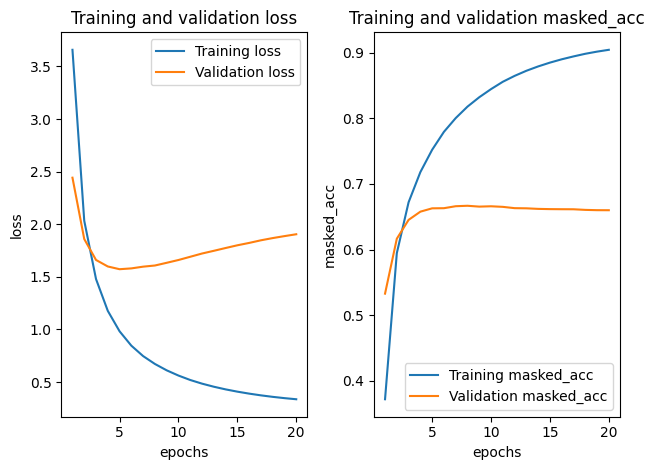

1.5727695226669312 The best number of epocs for the validation loss is 5
0.666725218296051 The best number of epocs for the validation accuracy is 8


In [13]:
# minimum viable params
# Epoch 24/50 - loss: 0.1224 - sparse_categorical_accuracy: 0.8007 - val_loss: 0.8010 - val_sparse_categorical_accuracy: 0.5755
FLAGS_learning_rate = 0.001
# It has been found out that the validation accuracy of this model turns to increasing within 20 epochs.
FLAGS_num_epochs = 20
FLAGS_steps_per_epoch = None
FLAGS_sequence_length = 20
FLAGS_vocab_size = 15000
FLAGS_batch_size = 64
FLAGS_num_encoders = 1
FLAGS_num_decoders = 1
FLAGS_num_heads = 6
FLAGS_intermediate_dim = 512
FLAGS_model_dim = 64
FLAGS_decay_steps = 100
FLAGS_decay_rate = 0.99

model, filepath, history = build_model(
    num_encoders=FLAGS_num_encoders,
    num_decoders=FLAGS_num_decoders,
    num_heads=FLAGS_num_heads,
    transformer_intermediate_dim=FLAGS_intermediate_dim,
    sequence_length=FLAGS_sequence_length,
    vocab_size=FLAGS_vocab_size,
    batch_size=FLAGS_batch_size,
    embedding_dim=FLAGS_model_dim,
    initial_learning_rate=FLAGS_learning_rate,
    decay_steps=FLAGS_decay_steps,
    decay_rate=FLAGS_decay_rate,
    epochs=FLAGS_num_epochs,
    steps_per_epoch=FLAGS_steps_per_epoch,
)
plot(history=history)

In [14]:
predict_main(
    filepath=filepath,
    examples=EXAMPLES,
    sequence_length=FLAGS_sequence_length,
)

ENGLISH SENTENCE:  Tom doesn't listen to anyone.
MACHINE TRANSLATED RESULT:  [start] tom no escucha nadie [end]
GOLDEN:  [start] Tomás no escucha a nadie. [end]
ENGLISH SENTENCE:  I got soaked to the skin.
MACHINE TRANSLATED RESULT:  [start] estoy empapado hasta la ropa interior [end]
GOLDEN:  [start] Estoy chorreando. [end]
ENGLISH SENTENCE:  I imagined that.
MACHINE TRANSLATED RESULT:  [start] yo me imaginé eso [end]
GOLDEN:  [start] Me imaginé eso. [end]
ENGLISH SENTENCE:  The baby is crying.
MACHINE TRANSLATED RESULT:  [start] el bebé está llorando [end]
GOLDEN:  [start] El bebé está llorando. [end]
ENGLISH SENTENCE:  I've never felt so exhilarated.
MACHINE TRANSLATED RESULT:  [start] nunca me he sentido tan animado [end]
GOLDEN:  [start] Nunca me he sentido tan animado. [end]
ENGLISH SENTENCE:  Please forgive me for not having written sooner.
MACHINE TRANSLATED RESULT:  [start] por favor perdóname por no haber escrito tarde [end]
GOLDEN:  [start] Perdóname por no haberte escrito a

In [ ]:
# default params
FLAGS_learning_rate = 0.001
FLAGS_num_epochs = 50 # default=1, but too small
FLAGS_steps_per_epoch = None
FLAGS_sequence_length = 20 # Input and output sequence length.
FLAGS_vocab_size = 15000 # Vocabulary size, required by tokenizer.
FLAGS_batch_size = 64
FLAGS_num_encoders = 2
FLAGS_num_decoders = 2
FLAGS_num_heads = 8 # Number of head of the multihead attention.
FLAGS_intermediate_dim = 128 # Intermediate dimension (feedforward network) of transformer.
FLAGS_model_dim = 64
FLAGS_decay_steps = 20
FLAGS_decay_rate = 0.98

model, filepath, history = build_model(
    num_encoders=FLAGS_num_encoders,
    num_decoders=FLAGS_num_decoders,
    num_heads=FLAGS_num_heads,
    transformer_intermediate_dim=FLAGS_intermediate_dim,
    sequence_length=FLAGS_sequence_length,
    vocab_size=FLAGS_vocab_size,
    batch_size=FLAGS_batch_size,
    embedding_dim=FLAGS_model_dim,
    initial_learning_rate=FLAGS_learning_rate,
    decay_steps=FLAGS_decay_steps,
    decay_rate=FLAGS_decay_rate,
    epochs=FLAGS_num_epochs,
    steps_per_epoch=FLAGS_steps_per_epoch,
)
plot(history=history)

In [ ]:
predict_main(
    filepath=filepath,
    examples=EXAMPLES,
    sequence_length=FLAGS_sequence_length,
)

In [ ]:
# FLAGS_learning_rate = 0.001 # pegasus: 0.0005 > text generation: 2e-6
# minimum viable params
FLAGS_learning_rate = 0.001
FLAGS_num_epochs = 50
FLAGS_steps_per_epoch = None
FLAGS_sequence_length = 20
FLAGS_vocab_size = 15000
FLAGS_batch_size = 64
FLAGS_num_encoders = 1
FLAGS_num_decoders = 1
FLAGS_num_heads = 6
FLAGS_intermediate_dim = 512
FLAGS_model_dim = 64
FLAGS_decay_steps = 20
FLAGS_decay_rate = 0.98

model, filepath, history = build_model(
    num_encoders=FLAGS_num_encoders,
    num_decoders=FLAGS_num_decoders,
    num_heads=FLAGS_num_heads,
    transformer_intermediate_dim=FLAGS_intermediate_dim,
    sequence_length=FLAGS_sequence_length,
    vocab_size=FLAGS_vocab_size,
    batch_size=FLAGS_batch_size,
    embedding_dim=FLAGS_model_dim,
    initial_learning_rate=FLAGS_learning_rate,
    decay_steps=FLAGS_decay_steps,
    decay_rate=FLAGS_decay_rate,
    epochs=FLAGS_num_epochs,
    steps_per_epoch=FLAGS_steps_per_epoch,
)
plot(history=history)

In [ ]:
predict_main(
    filepath=filepath,
    examples=EXAMPLES,
    sequence_length=FLAGS_sequence_length,
)

In [ ]:
# minimum viable params with no decay
# Epoch 24/50 - loss: 0.1224 - sparse_categorical_accuracy: 0.8007 - val_loss: 0.8010 - val_sparse_categorical_accuracy: 0.5755
FLAGS_learning_rate = 0.001
FLAGS_num_epochs = 50
FLAGS_steps_per_epoch = None
FLAGS_sequence_length = 20
FLAGS_vocab_size = 15000
FLAGS_batch_size = 64
FLAGS_num_encoders = 1
FLAGS_num_decoders = 1
FLAGS_num_heads = 6
FLAGS_intermediate_dim = 512
FLAGS_model_dim = 64
FLAGS_decay_steps = 100
FLAGS_decay_rate = 1.0

model, filepath, history = build_model(
    num_encoders=FLAGS_num_encoders,
    num_decoders=FLAGS_num_decoders,
    num_heads=FLAGS_num_heads,
    transformer_intermediate_dim=FLAGS_intermediate_dim,
    sequence_length=FLAGS_sequence_length,
    vocab_size=FLAGS_vocab_size,
    batch_size=FLAGS_batch_size,
    embedding_dim=FLAGS_model_dim,
    initial_learning_rate=FLAGS_learning_rate,
    decay_steps=FLAGS_decay_steps,
    decay_rate=FLAGS_decay_rate,
    epochs=FLAGS_num_epochs,
    steps_per_epoch=FLAGS_steps_per_epoch,
)
plot(history=history)

In [ ]:
predict_main(
    filepath=filepath,
    examples=EXAMPLES,
    sequence_length=FLAGS_sequence_length,
)